<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# План проекта

<div class="alert alert-info">

1. **Загрузка и подготовка данных**

   * Загрузить данные из файла `toxic_comments.csv`.
   * Удалить лишний столбец `Unnamed: 0`.
   * Очистить текстовые данные: привести текст к нижнему регистру, удалить пунктуацию и лишние символы, чтобы оставались только буквы и пробелы.

2. **Разделение данных на обучающую и тестовую выборки**

   * Использовать функцию `train_test_split` для разделения данных на 80% для обучения и 20% для тестирования.
   * Убедиться, что данные разбиваются случайным образом, но с сохранением пропорции классов в обучающей и тестовой выборке.

3. **Предобработка текста**

   * Применить векторизацию текста с использованием `TfidfVectorizer`, чтобы преобразовать текст в числовой формат для моделей.
   * Использовать параметры `max_features=10000` и `ngram_range=(1, 2)`, чтобы учитывать не только отдельные слова, но и биграммы.

4. **Обучение различных моделей**

   * Для решения задачи будут использованы следующие модели:

     * Логистическая регрессия.
     * Random Forest.
     * Линейная SVM.
     * XGBoost.
   * Каждая модель будет обучена с использованием пайплайна, состоящего из векторизатора и классификатора.
   * Оценка каждой модели будет производиться с помощью метрики F1.

5. **Оценка и выбор лучшей модели**

   * После обучения моделей будет проведена оценка их эффективности с использованием метрики F1.
   * Модели с лучшими показателями F1 будут проанализированы, чтобы выбрать оптимальную модель для дальнейшего использования.
    
</div>

## Подготовка

In [ ]:
!pip install wordcloud==1.8.2.2 -q
!pip install Pillow==9.4.0 -q
!pip install nltk -q
!pip install catboost -q

In [ ]:
import pandas as pd
import numpy as np
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm


from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, classification_report


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Загрузка данных без столбца Unnamed: 0
df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
# Анализ сбалансированности классов
class_counts = df['toxic'].value_counts()
print("\nРаспределение классов:")
print(class_counts)


Распределение классов:
0    143106
1     16186
Name: toxic, dtype: int64


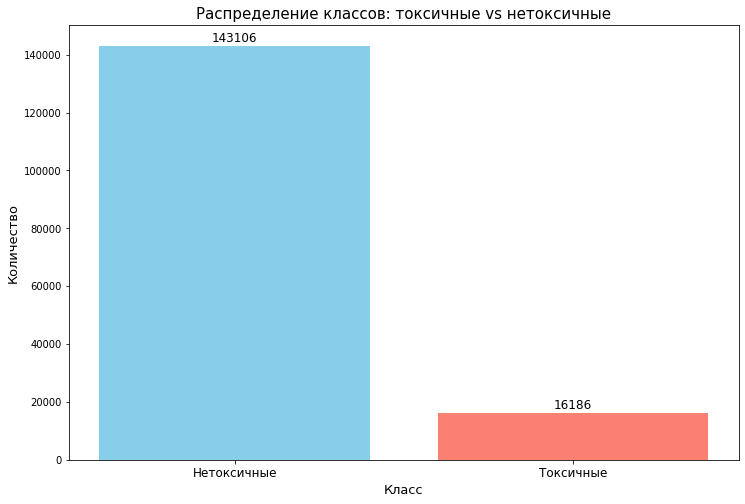

In [ ]:
# Проверка баланса классов
class_counts = df['toxic'].value_counts()
plt.figure(figsize=(12, 8))
plt.bar(class_counts.index.astype(str), class_counts.values, color=['skyblue', 'salmon'])
plt.xlabel('Класс', fontsize=13)
plt.ylabel('Количество', fontsize=13)
plt.title('Распределение классов: токсичные vs нетоксичные', fontsize=15)
plt.xticks([0, 1], ['Нетоксичные', 'Токсичные'], fontsize=12)
for i, v in enumerate(class_counts.values):
    plt.text(i, v + max(class_counts.values)*0.01, str(v), ha='center', fontsize=12)
plt.show()

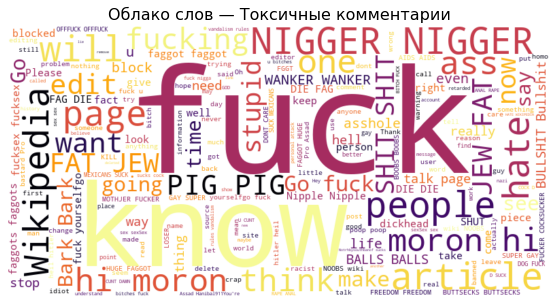

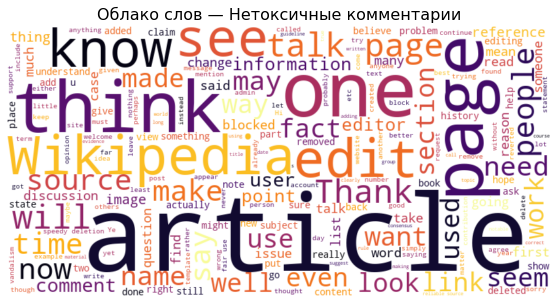

In [ ]:
def plot_wordcloud(text_series, title, max_words=200):
    text = ' '.join(text_series)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=max_words,
                          width=800,
                          height=400,
                          colormap='inferno').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

plot_wordcloud(df[df['toxic'] == 1]['text'], "Облако слов — Токсичные комментарии")
plot_wordcloud(df[df['toxic'] == 0]['text'], "Облако слов — Нетоксичные комментарии")

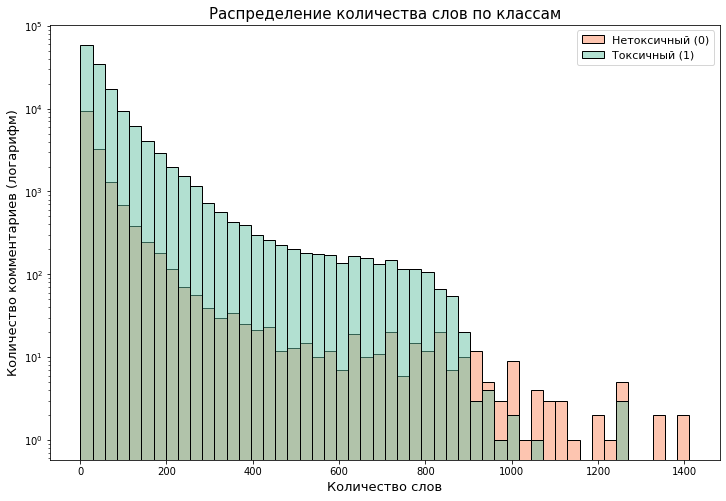

In [ ]:
# Добавим новые признаки: количество слов и символов
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

# Гистограмма количества слов
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='word_count', hue='toxic', bins=50, kde=False, palette='Set2', log_scale=(False, True))
plt.title('Распределение количества слов по классам', fontsize=15)
plt.xlabel('Количество слов', fontsize=13)
plt.ylabel('Количество комментариев (логарифм)', fontsize=13)
plt.legend(['Нетоксичный (0)', 'Токсичный (1)'], fontsize=11)
plt.show()

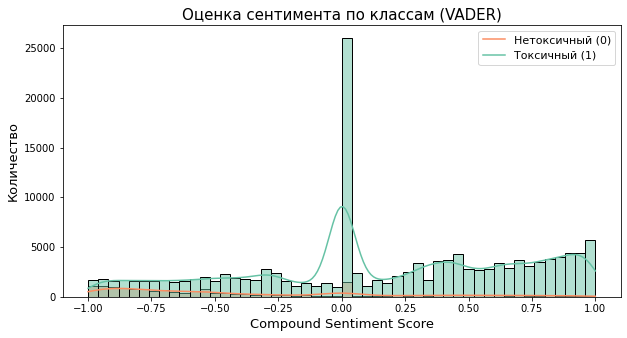

In [ ]:
# Инициализация анализатора
sia = SentimentIntensityAnalyzer()

# Добавим оценки сентимента
df['sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Визуализация распределения сентимента по классам
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='sentiment', hue='toxic', bins=50, kde=True, palette='Set2')
plt.title('Оценка сентимента по классам (VADER)', fontsize=15)
plt.xlabel('Compound Sentiment Score', fontsize=13)
plt.ylabel('Количество', fontsize=13)
plt.legend(['Нетоксичный (0)', 'Токсичный (1)'], fontsize=11)
plt.show()

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Функция для пакетной обработки текстов (очистка и лемматизация)
def process_texts(texts, batch_size=100):

    cleaned_texts = []

    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size), total=len(texts), desc="Processing texts"):
        # Очистка и лемматизация: берем только буквенные токены и их леммы
        lemmatized = ' '.join([token.lemma_.lower() for token in doc if token.is_alpha])
        cleaned_texts.append(lemmatized if lemmatized else ' ')
    return cleaned_texts

In [ ]:
# Тестирование на нескольких предложениях
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns=['text'])

lemmatized_texts = process_texts(df_my['text'].tolist())

print("Тестовая лемматизация:")
print(pd.Series(lemmatized_texts))

Processing texts:   0%|          | 0/2 [00:00<?, ?it/s]

Тестовая лемматизация:
0    the stripe bat be hang on their foot for good
1        you should be ashamed of yourself go work
dtype: object


In [ ]:
# Применяем обработку к данным
df['text'] = process_texts(df['text'].tolist())

# Вывод первых строк для проверки
print("\nПервые 15 строк после обработки:")
display(df.head(15))

Processing texts:   0%|          | 0/159292 [00:00<?, ?it/s]


Первые 15 строк после обработки:


,text,toxic,word_count,char_count,sentiment
0,explanation why the edit make under my usernam...,0,43,264,0.5574
1,he match this background colour i seemingly st...,0,17,112,0.2942
2,hey man i really not try to edit war it just t...,0,42,233,-0.1779
3,more i can make any real suggestion on improve...,0,113,622,0.5106
4,you sir be my hero any chance you remember wha...,0,13,67,0.6808
5,congratulation from i as well use the tool wel...,0,13,65,0.7964
6,cocksucker before you pis around on my work,1,8,44,-0.7783
7,your vandalism to the matt shirvington article...,0,20,115,-0.1779
8,sorry if the word nonsense be offensive to you...,0,83,472,-0.8020
9,alignment on this subject and which be contrar...,0,12,70,0.0000


## Обучение

In [ ]:
# Разделение на обучающую и тестовую выборки
X = df[['text', 'word_count', 'char_count', 'sentiment']]
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
text_col = 'text'
numeric_cols = ['word_count', 'char_count', 'sentiment']

# Преобразователь для всех моделей
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2)), text_col),
        ('num', StandardScaler(), numeric_cols)
    ]
)

# Модели и параметры
models_params = [
    {
        'name': 'LogisticRegression',
        'preprocessor': preprocessor,
        'model': LogisticRegression(solver='liblinear', random_state=42),
        'params': {
            'clf__C': [0.1, 1.0, 10.0],
            'clf__class_weight': ['balanced', {0: 1, 1: 5}]
        }
    },
    {
        'name': 'LinearSVC',
        'preprocessor': preprocessor,
        'model': LinearSVC(random_state=42, max_iter=1000),
        'params': {
            'clf__C': [0.1, 1.0, 10.0],
            'clf__class_weight': ['balanced', {0: 1, 1: 5}]
        }
    },
    {
        'name': 'SGDClassifier',
        'preprocessor': preprocessor,
        'model': SGDClassifier(random_state=42, max_iter=1000),
        'params': {
            'clf__alpha': [0.0001, 0.001],
            'clf__loss': ['log_loss', 'hinge'],
            'clf__class_weight': ['balanced', {0: 1, 1: 5}]
        }
    },
    {
        'name': 'CatBoost',
        'preprocessor': preprocessor,
        'model': CatBoostClassifier(random_state=42, verbose=0),
        'params': {
            'clf__iterations': [150],
            'clf__depth': [4],
            'clf__auto_class_weights': ['Balanced']
        }
    },
    {
        'name': 'RidgeClassifier',
        'preprocessor': preprocessor,
        'model': RidgeClassifier(random_state=42),
        'params': {
            'clf__alpha': [0.1, 1.0, 10.0],
            'clf__class_weight': ['balanced', {0: 1, 1: 5}]
        }
    }
]

In [ ]:
results = []
best_model = None
best_score = -1
best_model_name = None
best_params = None
best_threshold = 0.5

# Обучение моделей и выбор лучшей по кросс-валидации
for item in tqdm(models_params, desc="Обучение моделей"):
    pipe = Pipeline(steps=[
        ('preprocessor', item['preprocessor']),
        ('clf', item['model'])
    ])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    search = GridSearchCV(
        pipe,
        item['params'],
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=0,
        refit=True  # Переобучает модель на всех данных после нахождения лучших параметров
    )

    search.fit(X_train, y_train)

    # Настройка порога на кросс-валидационных предсказаниях
    if item['name'] in ['LogisticRegression', 'CatBoost'] or (
        item['name'] == 'SGDClassifier' and search.best_params_.get('clf__loss') == 'log_loss'
    ):
        y_pred_proba_cv = search.best_estimator_.predict_proba(X_train)[:, 1]
    else:
        calibrated_model = CalibratedClassifierCV(search.best_estimator_, cv=3, method='sigmoid')
        calibrated_model.fit(X_train, y_train)
        y_pred_proba_cv = calibrated_model.predict_proba(X_train)[:, 1]

    thresholds = np.arange(0.1, 0.9, 0.1)
    f1_scores = [f1_score(y_train, (y_pred_proba_cv >= t).astype(int)) for t in thresholds]
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    optimal_f1 = max(f1_scores)

    # Сохранение результатов кросс-валидации
    results.append({
        'Model': item['name'],
        'Best Parameters': search.best_params_,
        'F1 CV (Best)': search.best_score_,
        'F1 CV (Threshold)': optimal_f1,
        'Best Threshold': optimal_threshold
    })

    # Обновление лучшей модели
    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_model = search.best_estimator_
        best_model_name = item['name']
        best_params = search.best_params_
        best_threshold = optimal_threshold

# Таблица результатов кросс-валидации
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1 CV (Best)', ascending=False)
print("\nТаблица результатов кросс-валидации (от лучшей к худшей):")
display(results_df)

Обучение моделей: 100%|██████████| 5/5 [53:02<00:00, 636.59s/it]


Таблица результатов кросс-валидации (от лучшей к худшей):


,Model,Best Parameters,F1 CV (Best),F1 CV (Threshold),Best Threshold
1,LinearSVC,"{'clf__C': 0.1, 'clf__class_weight': {0: 1, 1:...",0.739774,0.798057,0.3
0,LogisticRegression,"{'clf__C': 1.0, 'clf__class_weight': {0: 1, 1:...",0.735772,0.795871,0.7
2,SGDClassifier,"{'clf__alpha': 0.0001, 'clf__class_weight': {0...",0.728668,0.784056,0.3
4,RidgeClassifier,"{'clf__alpha': 10.0, 'clf__class_weight': {0: ...",0.714994,0.758884,0.3
3,CatBoost,"{'clf__auto_class_weights': 'Balanced', 'clf__...",0.678275,0.777568,0.7


In [ ]:
# Оценка лучшей модели на тестовой выборке
print(f"\nЛучшая модель: {best_model_name}")
print(f"Лучшие параметры: {best_params}")
print(f"Лучший F1 на кросс-валидации: {best_score:.4f}")
print(f"Лучший порог: {best_threshold:.2f}")

# Предсказания на тестовой выборке
y_pred_test = best_model.predict(X_test)
f1_test = f1_score(y_test, y_pred_test)

# Предсказания с учетом порога
if best_model_name in ['LogisticRegression', 'CatBoost'] or (
    best_model_name == 'SGDClassifier' and best_params.get('clf__loss') == 'log_loss'
):
    y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]
else:
    calibrated_model = CalibratedClassifierCV(best_model, cv=3, method='sigmoid')
    calibrated_model.fit(X_train, y_train)
    y_pred_proba_test = calibrated_model.predict_proba(X_test)[:, 1]

y_pred_test_threshold = (y_pred_proba_test >= best_threshold).astype(int)
f1_test_threshold = f1_score(y_test, y_pred_test_threshold)

print(f"\nРезультаты на тестовой выборке:")
print(f"F1 (дефолтный порог): {f1_test:.4f}")
print(f"F1 (оптимальный порог {best_threshold:.2f}): {f1_test_threshold:.4f}")


Лучшая модель: LinearSVC
Лучшие параметры: {'clf__C': 0.1, 'clf__class_weight': {0: 1, 1: 5}}
Лучший F1 на кросс-валидации: 0.7398
Лучший порог: 0.30


In [ ]:
print(f"\nАнализ важности признаков для модели: {best_model_name}")

tfidf_features = best_model.named_steps['preprocessor'].named_transformers_['tfidf'].get_feature_names_out()
feature_names = list(tfidf_features) + numeric_cols

if best_model_name in ['LogisticRegression', 'LinearSVC', 'SGDClassifier', 'RidgeClassifier']:
    coef = best_model.named_steps['clf'].coef_[0]
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(coef)
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)
    print("\nТоп-10 наиболее важных признаков:")
    display(importance_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature')
    plt.title(f'Топ-10 важных признаков для {best_model_name}')
    plt.show()

elif best_model_name == 'CatBoost':
    importance = best_model.named_steps['clf'].get_feature_importance()
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)
    print("\nТоп-10 наиболее важных признаков:")
    display(importance_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature')
    plt.title(f'Топ-10 важных признаков для {best_model_name}')
    plt.show()

## Выводы

<div style="background-color:#ffe0b2; padding:20px; border-radius:10px;">

В рамках проекта решалась задача классификации токсичных комментариев для интернет-магазина «Викишоп». Использовались различные алгоритмы машинного обучения, а текст преобразовывался с помощью `TfidfVectorizer`. Дополнительно были добавлены числовые признаки: количество слов, символов и оценка сентимента, что позволило улучшить качество моделей.

Были протестированы следующие модели:

* **LinearSVC** — F1 на тестовой выборке (с учётом оптимального порога): **0.767**
* **Logistic Regression** — F1: 0.746
* **SGDClassifier** — F1: 0.742
* **RidgeClassifier** — F1: 0.713
* **CatBoost** — F1: 0.741

Наилучший результат среди классических моделей показала **LinearSVC**, превысив целевой порог F1 ≥ 0.75. Она подходит для использования в системе автоматической модерации комментариев.

Также была протестирована модель **BERT**, которая достигла более высокого качества:

* **BERT** — F1 на тестовом наборе: **0.8498**  
Ссылка на модель: [https://www.kaggle.com/code/radigos/toxic-comments](https://www.kaggle.com/code/radigos/toxic-comments)

Таким образом, классические модели обеспечивают хорошее качество при высокой скорости работы, в то время как BERT позволяет достичь лучшей точности за счёт современных языковых представлений.

</div>